In [11]:
from keras import layers
import keras

import matplotlib.pyplot as plt
import numpy as np

In [12]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 32

In [13]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 10)


In [14]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPooling2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = keras.ops.reshape(
            outputs,
            (
                -1,
                keras.ops.shape(outputs)[1] * keras.ops.shape(outputs)[2],
                keras.ops.shape(outputs)[-1],
            ),
        )
        return reshaped

In [15]:
class PositionEmbedding(keras.layers.Layer):
    def __init__(
        self,
        sequence_length,
        initializer="glorot_uniform",
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.initializer = keras.initializers.get(initializer)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "initializer": keras.initializers.serialize(self.initializer),
            }
        )
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="embeddings",
            shape=[self.sequence_length, feature_size],
            initializer=self.initializer,
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs, start_index=0):
        shape = keras.ops.shape(inputs)
        feature_length = shape[-1]
        sequence_length = shape[-2]
        # trim to match the length of the input sequence, which might be less
        # than the sequence_length of the layer.
        position_embeddings = keras.ops.convert_to_tensor(self.position_embeddings)
        position_embeddings = keras.ops.slice(
            position_embeddings,
            (start_index, 0),
            (sequence_length, feature_length),
        )
        return keras.ops.broadcast_to(position_embeddings, shape)

    def compute_output_shape(self, input_shape):
        return input_shape

In [16]:
class SequencePooling(layers.Layer):
    def __init__(self):
        super().__init__()
        self.attention = layers.Dense(1)

    def call(self, x):
        attention_weights = keras.ops.softmax(self.attention(x), axis=1)
        attention_weights = keras.ops.transpose(attention_weights, axes=(0, 2, 1))
        weighted_representation = keras.ops.matmul(attention_weights, x)
        return keras.ops.squeeze(weighted_representation, -2)

In [17]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (keras.ops.shape(x)[0],) + (1,) * (len(x.shape) - 1)
            random_tensor = keep_prob + keras.random.uniform(
                shape, 0, 1, seed=self.seed_generator
            )
            random_tensor = keras.ops.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [18]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.ops.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [19]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomCrop(image_size, image_size),
        layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [20]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        sequence_length = encoded_patches.shape[1]
        encoded_patches += PositionEmbedding(sequence_length=sequence_length)(
            encoded_patches
        )

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    weighted_representation = SequencePooling()(representation)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [21]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 92s 252ms/step - accuracy: 0.2702 - loss: 2.0659 - top-5-accuracy: 0.7579 - val_accuracy: 0.4810 - val_loss: 1.6152 - val_top-5-accuracy: 0.9254
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 86s 246ms/step - accuracy: 0.5152 - loss: 1.5408 - top-5-accuracy: 0.9371 - val_accuracy: 0.5924 - val_loss: 1.3752 - val_top-5-accuracy: 0.9602
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 87s 246ms/step - accuracy: 0.5962 - loss: 1.3769 - top-5-accuracy: 0.9580 - val_accuracy: 0.6182 - val_loss: 1.3375 - val_top-5-accuracy: 0.9608
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 87s 247ms/step - accuracy: 0.6418 - loss: 1.2852 - top-5-accuracy: 0.9646 - val_accuracy: 0.6674 - val_loss: 1.2430 - val_top-5-accuracy: 0.9752
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 87s 248ms/step - accuracy: 0.6753 - loss: 1.2152 - top-5-accuracy: 0.9738 - val_accuracy: 0.7052 - val_loss: 1.1635 - val_top-5-accuracy: 0.9758
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 87s 248ms/step - accuracy: 0.6985 -

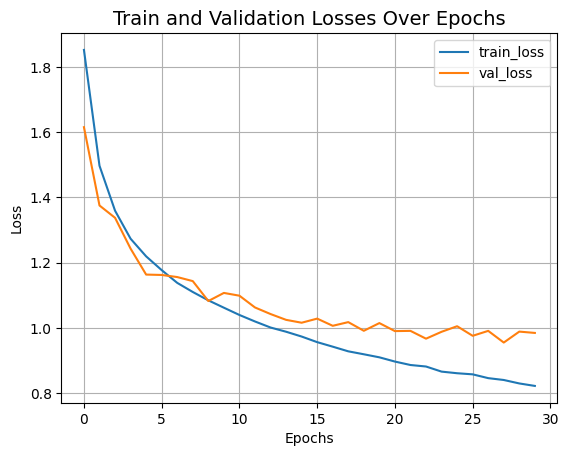

In [22]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()